
# Backcasting Analysis for Transitions
Backcasting is the science of taking a desired end goal and iteratively calculating the sequence of choices which lead to it. For example if we take the end goal as a bike friendly Prague, what decisions have to be made today to reach that end goal?

### Why is this analysis so Quantitative ?
Conventional scenario analysis is often centered around narratives which break up up key uncertainities. This is a time consuming process and has some important limitations. One is that it can gets very complex for more than a few uncertainities as the number of possibilties grows explosively. Two it becomes hard to keep track of all the possible decisions. 

For example if we take a simplified version of this model for biking in Prague : 
    -  Make decisions once in 5 years.
    -  6 Possible decisions or Policy Levers : Increasing Policy Coordination, Anti-Car Propaganda, Raise Prices Public Transport, Invest in Bike Infra, Lobby for Biking Finance, Levy Tax on Parking
    -  Each decision can have an effect on the share of biking. But decisions also interact with each other. For example increasing policy coordination will enhance the effectiveness of all policy measures. Anti-Car Propoganda can increase the chances of un-popular measures like parking taxes. 
Now if we take our end year as 2040. We have 3 sets of decisions to be made. 2^6 Possible decisions each period, for 3 periods that represents 262,144 possible transition paths. Now we have to find the ones which are successful. 


### How It Works
1. Initial Conditions: We start with the current modal split (biking, cars, public transport, and others) and set future goals for biking share.
2. Action Definition: We define a set of possible policy actions, each with specific effects, limitations, and interactions.
Mean Field Approximation: This crucial component models the aggregate response of all other agents in the system (e.g., car manufacturers, oil companies, status quo supporters) to our policy actions and changing modal shares.
State Transition Exploration: The script systematically explores all possible combinations of actions over time, creating a comprehensive map of potential futures.
Path Identification: It identifies paths that reach the desired biking share goals, considering both direct effects of actions and the Mean Field response.
6. Optimization: The script determines the most efficient path - the one that reaches the goal with the fewest actions, considering both effectiveness and societal pushback.
Visualization: It generates a graph showing the evolution of biking share over time along the optimal path, including the timing of policy actions.

### User Inputs and Their Effects
You can change various inputs to explore different scenarios:

TIME_PERIODS: Adjust the number of time steps in your analysis.

initial_modal_shares: Change the starting percentages for each transportation mode.

final_states: Modify the target biking share percentages. We have used 4% as the baseline, with 7% being realistic and 20% as the dream. 

ACTIONS: You can define the full set of actions that the city can take. Note however this dramatically increases the model complexity and it might take much longer to find a solution. 
For each action, you can adjust:
    effects: How much it changes each mode's share. For example raising public transport fares might increase car and bike shares.
    cooldown: How long before the action can be used again.
    one_time: Whether the action can only be used once.
    success_probability: The chance the action will work.
    interactions: How this action affects the success of other actions.
    costs: Each action can have an associated cost, for example investing in biking infrastructure is expensive and might not pay off. 
MEAN_FIELD_EFFECTS: This calculates the aggregate reaction of all other agents in the system to our policy response. In our case they represent the status quo who want to retain the current car centric modal share.
 
utility_function: Change how the "goodness" of a particular modal split is calculated.Both our city and our opposition(MEAN_FEILD_EFFECTS) value the modal shift differently and have different costs for their respective actions. 

EXOGENOUS_FACTORS: Add external influences that happen at specific times. Not yet implemented but factors like E-bikes, EU policy, weather, Pandemics affect the state transtitions and can be modelled by their probabiliy distributions.


In [1]:
import itertools
import numpy as np
from collections import deque
import matplotlib.pyplot as plt


In [2]:
# ------------------------- User Input Section -------------------------

# Time periods
TIME_PERIODS = [1, 2, 3, 4]

# Define actions and their indices
DECISIONS = ['IPC', 'ACP', 'RPPT', 'IBI', 'LBF', 'LTP']
DECISION_INDICES = {name: idx for idx, name in enumerate(DECISIONS)}

# Initial modal shares (should sum to 1)
initial_modal_shares = {
    's': 0.01,  # Initial biking modal share
    'c': 0.50,  # Initial car modal share
    'p': 0.40,  # Initial public transport modal share
    'o': 0.09   # Other transport modes (calculated to sum to 1)
}

# Desired final biking modal shares
final_states = [0.20, 0.07, 0.04]  # Desired final biking modal shares

# Action definitions
class Action:
    def __init__(self, name, effects=None, cooldown=None, preparation=None, one_time=False,
                 success_probability=1.0, conditions=None, interactions=None):
        self.name = name
        self.effects = effects if effects is not None else {}  # Effects on modal shares
        self.cooldown = cooldown          # Cooldown periods after action execution
        self.preparation = preparation    # Preparation periods before action takes effect
        self.one_time = one_time          # Whether the action can be taken only once
        self.success_probability = success_probability  # Base success probability
        self.conditions = conditions if conditions is not None else {}  # Conditions for success
        self.interactions = interactions if interactions is not None else {}  # Interactions with other actions

    def evaluate_success_probability(self, executed_actions):
        # Evaluate success probability based on conditions and interactions
        probability = self.success_probability
        for condition_action, required_state in self.conditions.items():
            if executed_actions.get(condition_action, 0) != required_state:
                probability = 0.0
        for interaction_action, adjustment in self.interactions.items():
            if executed_actions.get(interaction_action, 0) == 1:
                probability += adjustment
        # Ensure probability is within [0, 1]
        probability = min(max(probability, 0.0), 1.0)
        return probability

# Define the actions with their parameters
ACTIONS = {
    'IPC': Action(
        name='IPC',
        cooldown=2
    ),
    'ACP': Action(
        name='ACP',
        effects={'s': 0.01, 'c': -0.005},
        cooldown=1
    ),
    'RPPT': Action(
        name='RPPT',
        effects={'p': -0.005, 's': -0.0025, 'c': -0.0025},
        one_time=True
    ),
    'IBI': Action(
        name='IBI',
        effects={'s': 0.02, 'c': -0.01},
        one_time=True,
        success_probability=0.2,
        interactions={
            'IPC': 0.4,  # Increases success probability by 0.4 if IPC is executed
            'LBF': 0.4   # Increases success probability by 0.4 if LBF is executed
        }
    ),
    'LBF': Action(
        name='LBF',
        cooldown=1
    ),
    'LTP': Action(
        name='LTP',
        effects={'c': -0.007, 's': -0.0035, 'p': -0.0035},
        one_time=True
    )
}

# Mean-field approximation parameters
MEAN_FIELD_EFFECTS = {
    'base': {'c': 0.005, 'p': -0.003},  # Base adjustments to modal shares
    'reactions': {  # Adjustments based on our actions
        'ACP': {'c': 0.002},
        'LTP': {'c': 0.002}
    }
}

# Utility function (for example purposes)
def utility_function(modal_shares):
    # Define the utility based on modal shares
    target_biking_share = 0.2
    utility = -((modal_shares['s'] - target_biking_share) ** 2)
    return utility

# Exogenous factors (if any)
EXOGENOUS_FACTORS = {
    # Define exogenous effects on modal shares (e.g., seasonal effects)
    # Time period as key, adjustments as values
    # Example: {2: {'s': 0.01, 'c': -0.005}}
}



Total feasible paths to desired final states: 55860

Most Parsimonious Path:
  Time 1: Decisions: ['ACP'], S: 0.020, C: 0.502, P: 0.397, O: 0.081
  Time 2: Decisions: [], S: 0.020, C: 0.507, P: 0.394, O: 0.079
  Time 3: Decisions: ['IBI'], S: 0.040, C: 0.502, P: 0.391, O: 0.067
  Time 4: Decisions: [], S: 0.040, C: 0.507, P: 0.388, O: 0.065




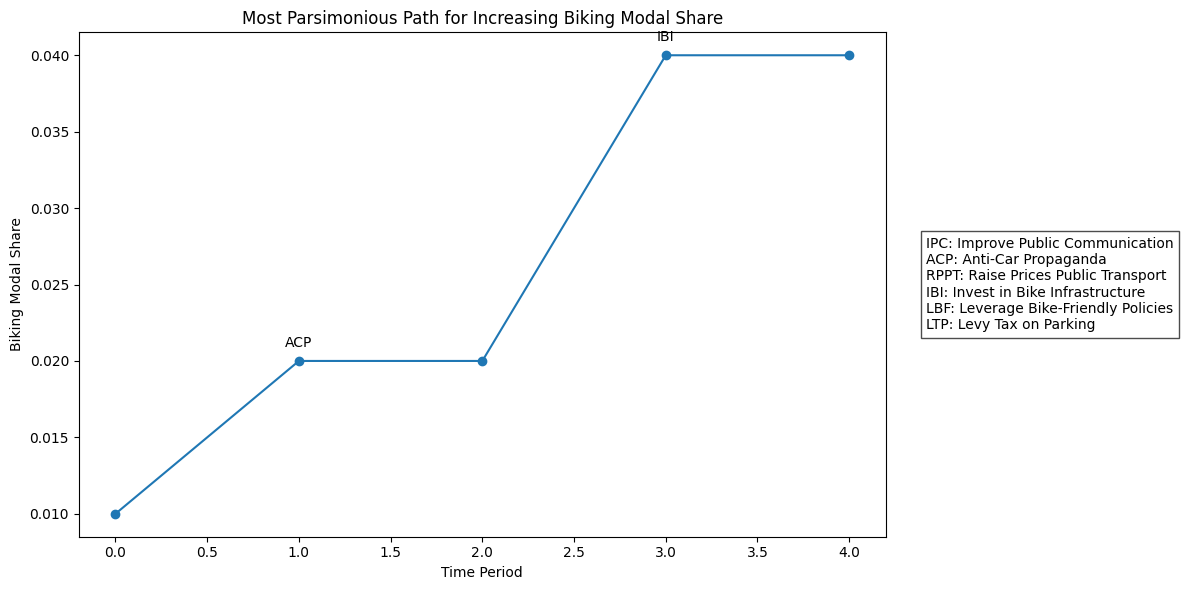

In [3]:

# ------------------------- End of User Input Section -------------------------

# State node representation

class StateNode:

    def __init__(self, time, modal_shares, decisions=None, parent=None,

                 cooldowns=None, disabled_actions=None):

        self.time = time

        self.modal_shares = modal_shares.copy()

        self.decisions = decisions  # Decisions taken to reach this state

        self.parent = parent        # Parent StateNode

        self.children = []          # Child StateNodes



        # Cooldowns: mapping action name to remaining cooldown periods

        if cooldowns is None:

            self.cooldowns = {action: 0 for action in DECISIONS}

        else:

            self.cooldowns = cooldowns.copy()



        # Disabled actions: set of actions that are disabled

        if disabled_actions is None:

            self.disabled_actions = set()

        else:

            self.disabled_actions = disabled_actions.copy()



    def __repr__(self):

        modal_shares_str = ', '.join([f"{k}: {v:.3f}" for k, v in self.modal_shares.items()])

        return (f"Time: {self.time}, {modal_shares_str}, Decisions: {self.decisions}")



# Mean-field approximation for other players' response

def mean_field_response(modal_shares, decisions):

    # Start with base effects

    mf_effects = MEAN_FIELD_EFFECTS['base'].copy()

    # Adjustments based on our decisions

    for action_name, adjustments in MEAN_FIELD_EFFECTS['reactions'].items():

        idx = DECISION_INDICES[action_name]

        if decisions[idx]:

            for mode, delta in adjustments.items():

                mf_effects[mode] = mf_effects.get(mode, 0) + delta

    return mf_effects



# State transition function

def state_transition(modal_shares_prev, decisions):

    modal_shares = modal_shares_prev.copy()

    D = decisions



    # Map decisions to action names for easy access

    executed_actions = {action_name: D[DECISION_INDICES[action_name]] for action_name in DECISIONS}



    # Actions that need to be disabled (e.g., failed actions)

    actions_to_disable = set()



    # Apply action effects

    for action_name, action in ACTIONS.items():

        if executed_actions.get(action_name, 0):

            # Evaluate success probability

            success_prob = action.evaluate_success_probability(executed_actions)

            success = np.random.rand() <= success_prob  # Simulate success

            if success:

                for mode, delta in action.effects.items():

                    modal_shares[mode] += delta

            else:

                # If action fails and is one-time, disable it

                if action.one_time:

                    actions_to_disable.add(action_name)



    # Mean-field response from other players

    mf_effects = mean_field_response(modal_shares_prev, decisions)

    for mode, delta in mf_effects.items():

        modal_shares[mode] += delta



    # Exogenous factors

    exogenous_effects = EXOGENOUS_FACTORS.get(len(TIME_PERIODS), {})

    for mode, delta in exogenous_effects.items():

        modal_shares[mode] += delta



    # Ensure modal shares sum to 1 and are within [0,1]

    total_share = sum(modal_shares.values())

    if total_share != 1:

        # Adjust 'other' share to balance the total to 1

        modal_shares['o'] = 1 - sum([modal_shares[mode] for mode in ['s', 'c', 'p']])



    # Clip modal shares to [0,1]

    for mode in modal_shares:

        modal_shares[mode] = min(max(modal_shares[mode], 0), 1)



    return modal_shares, actions_to_disable



# Build the state-transition graph

def build_graph(initial_modal_shares, final_states):

    root = StateNode(time=0, modal_shares=initial_modal_shares)

    queue = deque([root])

    paths = []



    while queue:

        current_node = queue.popleft()



        if current_node.time == len(TIME_PERIODS):

            # Check if final biking share matches desired final states

            if np.isclose(current_node.modal_shares['s'], final_states, atol=0.005).any():

                # Backtrack to get the path

                path = []

                node = current_node

                while node.parent is not None:

                    path.append({

                        'time': node.time,

                        'decisions': node.decisions,

                        'modal_shares': node.modal_shares

                    })

                    node = node.parent

                path.reverse()

                paths.append(path)

            continue



        # Decrease cooldowns

        cooldowns_next = {action: max(current_node.cooldowns[action] - 1, 0) for action in DECISIONS}



        # Determine available actions

        available_actions = [action for action in DECISIONS

                             if cooldowns_next[action] == 0 and action not in current_node.disabled_actions]



        # Generate all possible combinations of available actions (power set)

        action_combinations = []

        for r in range(len(available_actions) + 1):

            action_combinations.extend(itertools.combinations(available_actions, r))



        # For each combination, create the decision vector

        for action_subset in action_combinations:

            decisions = [0] * len(DECISIONS)

            for action in action_subset:

                idx = DECISION_INDICES[action]

                decisions[idx] = 1



            # Simulate state transition

            modal_shares_next, actions_to_disable = state_transition(

                current_node.modal_shares,

                decisions

            )



            # Update cooldowns and disabled actions

            cooldowns_updated = cooldowns_next.copy()

            disabled_actions_updated = current_node.disabled_actions.copy()



            # Set cooldowns and disable actions as needed

            for action in action_subset:

                action_obj = ACTIONS[action]

                idx = DECISION_INDICES[action]

                # Set cooldown if action has a cooldown

                if action_obj.cooldown is not None:

                    cooldowns_updated[action] = action_obj.cooldown

                # Disable one-time actions

                if action_obj.one_time:

                    disabled_actions_updated.add(action)



            # Disable actions that failed

            disabled_actions_updated.update(actions_to_disable)



            # Create child node

            child_node = StateNode(

                time=current_node.time + 1,

                modal_shares=modal_shares_next,

                decisions=decisions,

                parent=current_node,

                cooldowns=cooldowns_updated,

                disabled_actions=disabled_actions_updated

            )

            current_node.children.append(child_node)

            queue.append(child_node)

    return paths



# Execute the graph building

paths = build_graph(initial_modal_shares, final_states)



# Display the results

print(f"Total feasible paths to desired final states: {len(paths)}\n")



# Find and visualize the most parsimonious path

def count_positive_decisions(path):

    return sum(sum(step['decisions']) for step in path)



def count_repeat_decisions(path):

    decision_sets = [set(i for i, d in enumerate(step['decisions']) if d == 1) for step in path]

    return sum(len(set1.intersection(set2)) for set1, set2 in zip(decision_sets, decision_sets[1:]))



def find_most_parsimonious_path(paths):

    if not paths:

        return None

    

    sorted_paths = sorted(

        paths,

        key=lambda p: (count_positive_decisions(p), count_repeat_decisions(p))

    )

    return sorted_paths[0]



def visualize_parsimonious_path(path):

    times = [0] + [step['time'] for step in path]

    shares = [initial_modal_shares['s']] + [step['modal_shares']['s'] for step in path]

    

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(times, shares, marker='o')

    

    for i, step in enumerate(path):

        decision_names = [DECISIONS[i] for i, d in enumerate(step['decisions']) if d == 1]

        if decision_names:

            ax.annotate(', '.join(decision_names), (step['time'], step['modal_shares']['s']), 

                        textcoords="offset points", xytext=(0,10), ha='center')

    

    ax.set_xlabel('Time Period')

    ax.set_ylabel('Biking Modal Share')

    ax.set_title('Most Parsimonious Path for Increasing Biking Modal Share')

    

    # Add legend

    legend_text = '\n'.join([f"{abbr}: {name}" for abbr, name in zip(DECISIONS, [

        "Improve Public Communication",

        "Anti-Car Propaganda",

        "Raise Prices Public Transport",

        "Invest in Bike Infrastructure",

        "Leverage Bike-Friendly Policies",

        "Levy Tax on Parking"

    ])])

    ax.text(1.05, 0.5, legend_text, transform=ax.transAxes, 

            bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),

            verticalalignment='center')

    

    plt.tight_layout()

    plt.show()



most_parsimonious_path = find_most_parsimonious_path(paths)



if most_parsimonious_path:

    print("Most Parsimonious Path:")

    for step in most_parsimonious_path:

        decision_names = [DECISIONS[i] for i, d in enumerate(step['decisions']) if d == 1]

        modal_shares_str = ', '.join([f"{k.upper()}: {v:.3f}" for k, v in step['modal_shares'].items()])

        print(f"  Time {step['time']}: Decisions: {decision_names}, {modal_shares_str}")

    print("\n")

    

    visualize_parsimonious_path(most_parsimonious_path)

else:

    print("No feasible paths found.")


